<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 8 - XGBoost Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[XGBoost Classifier](#xgboost-model)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# XGBoost Classifier Introduction <a class="anchor" id="introduction"></a>

XGBoost is a popular software package that implements a type of boosting called gradient boosting. The key idea here is that of _boosting_: an ensemble method in which contributions from many weak learners are combined to make a single strong learner. A weak learner is barely correlated with the truth, correct perhaps 53% of the time. Most approaches to boosting combine a weighted sum of many weak learners to yield a strong learner, highly correlated with the correct output. Gradient boosting provides a general framework in which an arbitrary differntiable loss function can be optimized. As with random forests, the methodology used in boosting is general and need not to refer to a decision tree context, but decision tree stumps (shallow trees) are a popular choice of weak learner. 

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** As mentioned above, the gradient boosting framework is not inherently related to decision trees. However, since trees are a popular choice of weak learner, the discussion here will assume a context of trees. This means that everything discussed in the [decision trees notebook](6.0-dt-mwi.ipynb) applies here, except that the gradient boosting approach mitigates problems with bias and variance.

**Algorithm and Training.** We will first introduce boosting as stagewise additive modeling, and then consider the role of gradients.

Boosting is an iterative process that starts with a simple base learner. For example, consider a decision tree with a single split (this is called a decision stump). That split is made on the basis of optimizing some loss function. Of course, the split doesn't get everything right. The difference between the predicted and true values is called a residual. There is a residual associated to each training point.

The key idea in boosting is to utilize those residuals and their labels as training data to fit _another_ weak learner, or in our case another stump. Now we have two stumps, and each one uses all of the training data at hand (as opposed to a restricted subset of the data as in normal tree growing procedures). Next, we update the model by adding the new stump to the previous ones as a weighted sum. The weight $\gamma_{m}$ of the $m^{th}$ weak learner is determined as the value that minimizes the loss function when used as the weight. The model is now updated with the new "expert knowledge" of the $m^{th}$ weak learner, and process is repeated until a stopping condition is met.

Boosting becomes gradient boosting when, instead of fitting the next weak learner to the _residuals_ of the current model, one fits the next weak learner to the values produced by evaluating the gradient of the loss function (with respect to the predictions of the current model). These values are called _pseudo-residuals_ and we now say that the next base learner is fit to the pseudo-residuals of the previous step. As in regualr boosting, the addition of the next weak learner is weighted by a value that minimizes loss.


The learning procedure continues in this fashion until a stopping condition is met. A common approach to stopping involves training on subsamples of data, measuring the out-of-bag (OOB) error at each step, and stopping once the error levels out. Another approach would be to simply stop after $m$ weak learners have been trained.

## Considerations <a class="anchor" id="introduction-considerations"></a>

We have seen that boosting, although an ensemble method, is quite distinct from bagging. Boosting is thought to be superior in the quest to mitigate overfitting by trees. In the context of decision trees, the standard view that boosting is better than random forests, which are better than merely bagging, which is better than using a single tree. It should also be noted that, while the trees in a random forest may grow quite large and become quite bushy, the boosted trees typically have between 4 and 8 leaves, making them relatively shallow.

A common regularization technique in boosting contexts involves using an additional "shrinkage" parameter, usually some value less than 0.1, to further weight contributions by new weak learners. This amounts to adding in a "learning rate," and while it typically improves performance it comes at the cost of more computation. Other regularization techniques are those used in all tree contexts: minimum observations and penalty for tree complexity (number of nodes).

It is possible to use a variant of the LASSO technique for tree post selection, and shrink the resulting collection of trees. A tree transforms an input to some number or class. If we pass all the inputs through a tree, we get a vector of numbers. If we build that vector for every tree in our boosted model, we get a collection of vectors. We can then treat those vectors as variables in a linear regression and seek to optimally weight them using an $l_{1}$ regularized loss function. In the process, some weights (and by extension some trees) will be zeroed out and a subset of trees will remain. 

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'xgb'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# XGBoost Classifier Model <a class="anchor" id="xgb-model"></a>

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 237 ms, sys: 774 µs, total: 238 ms
Wall time: 238 ms
CPU times: user 23.3 ms, sys: 1.92 ms, total: 25.2 ms
Wall time: 24.6 ms
In-sample score: 76.89%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/

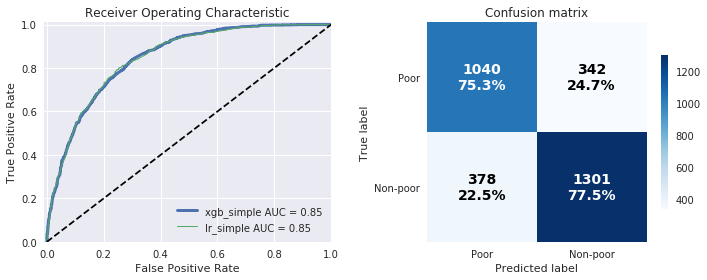

,xgb_simple,lr_simple
accuracy,0.764783,0.766743
recall,0.752533,0.738784
precision,0.733427,0.743086
f1,0.742857,0.740929
cross_entropy,0.476656,0.478969
roc_auc,0.847671,0.847856
cohen_kappa,0.526186,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 59.65% 


In [5]:
from xgboost import XGBClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

The XGBClassifier model provides feature importances, so we can inspect and rank the features

In [6]:
feat_imps

,importance
der_nchild10under,0.250370
der_nliterate,0.174815
der_nmalesover10,0.160000
der_nfemalesover10,0.134815
cons_0508__Yes,0.091852
hld_electricity__Yes,0.060741
cons_0504__Yes,0.059259
der_nemployedpastyear,0.041481
hld_toilet__None,0.026667


## XGBoost with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

CPU times: user 7.77 s, sys: 66.2 ms, total: 7.84 s
Wall time: 7.84 s
CPU times: user 88.2 ms, sys: 42.9 ms, total: 131 ms
Wall time: 130 ms
In-sample score: 89.15%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/

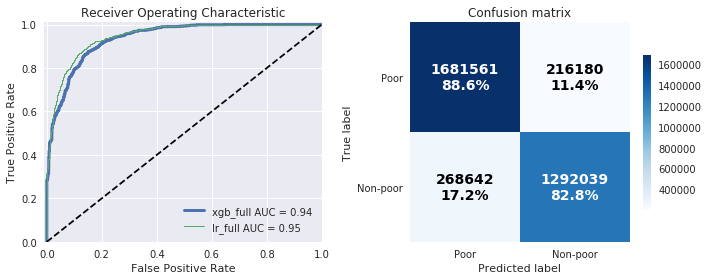

,xgb_full,lr_full
accuracy,0.859814,0.873897
recall,0.886085,0.869754
precision,0.862249,0.853693
f1,0.874005,0.861649
cross_entropy,0.321812,0.288223
roc_auc,0.937449,0.948658
cohen_kappa,0.731838,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 56.00% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>



Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out 

[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.869352204681546, total=  13.5s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.4s remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8671747414262384, total=  13.5s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8851388132825259, total=  13.3s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8812636165577342, total=  13.5s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.883442265795207, total=  13.3s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8628198149156233, total=  21.2s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8666303756124115, total=  21.1s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8840500816548721, total=  21.0s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8850762527233116, total=  21.1s
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8 


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished


[CV]  colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8, score=0.8850762527233116, total=  21.2s
CPU times: user 12min 31s, sys: 1.97 s, total: 12min 33s
Wall time: 3min 12s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 323 ms, sys: 40 ms, total: 363 ms
Wall time: 360 ms
In-sample score: 93.78%
Best model parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1430, 'silent': 0, 'subsample': 0.8}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


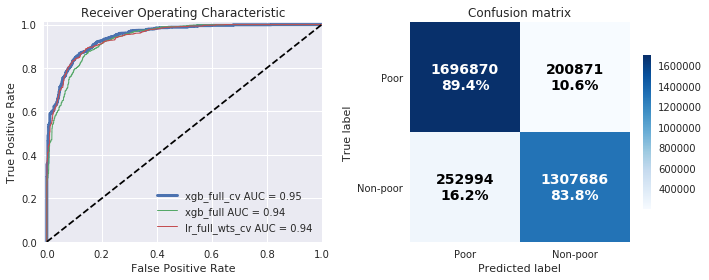

,xgb_full_cv,xgb_full,lr_full_wts_cv
accuracy,0.868765,0.859814,0.873458
recall,0.894152,0.886085,0.891581
precision,0.87025,0.862249,0.87947
f1,0.882039,0.874005,0.885484
cross_entropy,0.295551,0.321812,0.300498
roc_auc,0.947721,0.937449,0.944474
cohen_kappa,0.750765,0.731838,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.14% 


In [8]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = XGBClassifier()
parameters = {'max_depth': np.arange(3,6,2),
              'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000],
              'seed': [1430]
             }
fit_params = {'sample_weight': w_train}
model = GridSearchCV(estimator, parameters, fit_params=fit_params, verbose=3, cv=5)
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

This gives us a noticeable boost in performance, with a better recall and much lower cross-entropy than the default model. 

In [9]:
feat_imps.head(20)

,importance
der_hhsize,0.071325
hld_rooms,0.022859
der_nchild10under,0.020978
hld_nbcellpho,0.015191
cons_0508__Yes,0.011863
der_nliterate,0.011574
cons_0505__Yes,0.010706
der_nmalesover10,0.010417
der_nfemalesover10,0.009983
cons_0410__Yes,0.009693


# Feature selection <a class="anchor" id="feature-selection"></a>

Since this model provides feature importances, we can easily remove features that do not contribute much to the model. For example, we can filter our features to only those that contribute 80% of the model importance. In the case of filtering consumable features, we can quickly see which are most useful and filter it to the top 50 or less.

X shape after feature selection:  (9183, 257)
CPU times: user 35.8 s, sys: 68 ms, total: 35.8 s
Wall time: 8.99 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 330 ms, sys: 3.99 ms, total: 334 ms
Wall time: 332 ms
In-sample score: 92.64%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


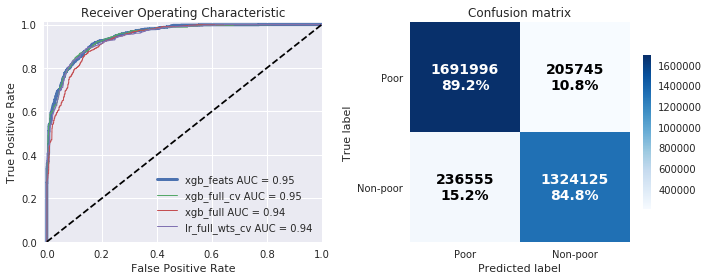

,xgb_feats,xgb_full_cv,xgb_full,lr_full_wts_cv
accuracy,0.872109,0.868765,0.859814,0.873458
recall,0.891584,0.894152,0.886085,0.891581
precision,0.87734,0.87025,0.862249,0.87947
f1,0.884405,0.882039,0.874005,0.885484
cross_entropy,0.289181,0.295551,0.321812,0.300498
roc_auc,0.948603,0.947721,0.937449,0.944474
cohen_kappa,0.754271,0.750765,0.731838,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.96% 


In [10]:
feats = feat_imps[feat_imps.cumsum() <= 0.90].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
print("X shape after feature selection: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train.as_matrix(), y_train)

# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_full_cv',
                                                    'xgb_full',
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [11]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

120 consumables features selected:
Chicken
Goat
Pumpkin
Thobwa
Green maize
Maize ufa refined (fine flour)
Rice
Public transport - Bus/Minibus
Bean, white
Charcoal
Cooking oil
Eggs
Banana
Beef
Dried fish
Fresh milk
Bean, brown
Groundnut flour
Fresh fish
Cigarettes or other tobacco
Smoked fish
Groundnut
Bicycle service, repair, or parts
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Small animal - rabbit, mice, etc.
Sugar
Pork
Termites, other insects (eg Ngumbi, caterpillar)
Paraffin lamp (hurricane or pressure)
Public transport - Bicycle Taxi
Irish potato
Bread
Tea
Guava
Clothes soap (powder)
Soft drinks (Coca-cola, Fanta, Sprite, etc.)
Chinese cabbage
Boy's shoes
Bowls, glassware, plates, silverware, etc.
Donation - to church, charity, beggar, etc.
Cassava tubers
Sweets, candy, chocolates
Girl's dress/skirt
Repairs & maintenance to dwelling
Glycerine, Vaseline, skin creams
Matches
Buns, scones
Cassava flour
Citrus - naartje, orange, etc.
Sorghum (mapira

# Random Forest Classifier Malawi Summary <a class="anchor" id="summary"></a>



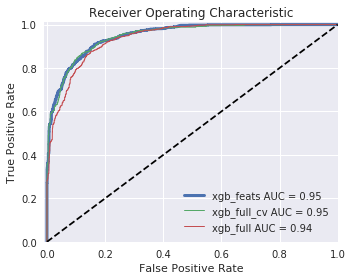

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
xgb_feats,0.872109,0.891584,0.87734,0.884405,0.289181,0.948603,0.754271,0.00847763
xgb_full_cv,0.868765,0.894152,0.87025,0.882039,0.295551,0.947721,0.750765,0.0103505
xgb_full,0.859814,0.886085,0.862249,0.874005,0.321812,0.937449,0.731838,0.01896


In [12]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)